In [0]:
try: 
    from google.colab import drive
    drive.mount('/content/drive')
    in_google_colab = True
    %tensorflow_version 1.x
except:
    in_google_colab = False

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('Tensorflow version is {}'.format(tf.__version__))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 1.x selected.
Found GPU at: /device:GPU:0
Tensorflow version is 1.15.2


In [0]:
if in_google_colab:
    print("Currently in google colab, unpacking the files")
    !rm -r /content/mask_rcnn_envir
    !unzip /content/drive/'My Drive'/mask_rcnn_envir.zip  -d /content
    %cd mask_rcnn_envir/
else:
    print("Not in google colab")

Currently in google colab, unpacking the files
rm: cannot remove '/content/mask_rcnn_envir': No such file or directory
Archive:  /content/drive/My Drive/mask_rcnn_envir.zip
   creating: /content/mask_rcnn_envir/.ipynb_checkpoints/
  inflating: /content/mask_rcnn_envir/.ipynb_checkpoints/CA1 v1 Colab Version (edited, to 1 script, v2)-checkpoint.ipynb  
   creating: /content/mask_rcnn_envir/__pycache__/
  inflating: /content/mask_rcnn_envir/__pycache__/mask_rcnn_v2.cpython-36.pyc  
   creating: /content/mask_rcnn_envir/annotations/
  inflating: /content/mask_rcnn_envir/annotations/instances_openimagev5tococo_train2020.json  
  inflating: /content/mask_rcnn_envir/annotations/instances_openimagev5tococo_val2020.json  
  inflating: /content/mask_rcnn_envir/CA1 v1 - combined.ipynb  
  inflating: /content/mask_rcnn_envir/CA1 v1 Colab Version (edited, to 1 script, v2).ipynb  
  inflating: /content/mask_rcnn_envir/final_segmentation_metadata.csv  
  inflating: /content/mask_rcnn_envir/mask_rcnn

In [0]:
from mask_rcnn_v2 import Config, MaskRCNN, buildMASKRCNN, Dataset, CocoLikeDataset, display_top_masks, display_instances
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import json
from PIL import Image, ImageDraw
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model

from os import listdir
from xml.etree import ElementTree

from pycocotools import mask as maskUtils

from imgaug import augmenters as iaa

import pandas as pd

%matplotlib inline

Using TensorFlow backend.


In [0]:
class myMaskRCNNConfig(Config):
    NAME = 'MaskRCNN_config'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 3 + 1
    #self.IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + self.NUM_CLASSES
    
    STEPS_PER_EPOCH = 131

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512     

    BACKBONE = 'resnet101'                       

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256) 
    
    RPN_NMS_THRESHOLD = 0.8

    DETECTION_MIN_CONFIDENCE = 0.7

In [0]:
config = myMaskRCNNConfig()

In [0]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/mask_rcnn_envir/annotations/instances_openimagev5tococo_train2020.json', '/content/mask_rcnn_envir/openimagev5tococo_train2020')
dataset_train.prepare()

step 1: load json successfully
step 2: add class name successfully
step 3: get annotation successfully
step 4: get images successfully


In [0]:
dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/mask_rcnn_envir/annotations/instances_openimagev5tococo_val2020.json', '/content/mask_rcnn_envir/openimagev5tococo_val2020')
dataset_val.prepare()

step 1: load json successfully
step 2: add class name successfully
step 3: get annotation successfully
step 4: get images successfully


In [0]:
dataset_train.class_names

['BG', 'Dress', 'Suit', 'Jeans']

In [0]:
dataset_val.class_names

['BG', 'Dress', 'Suit', 'Jeans']

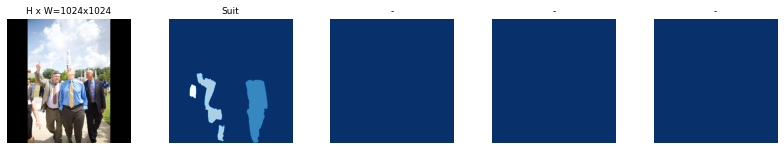

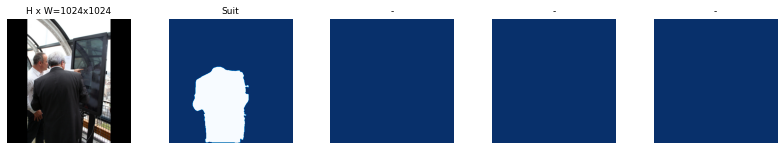

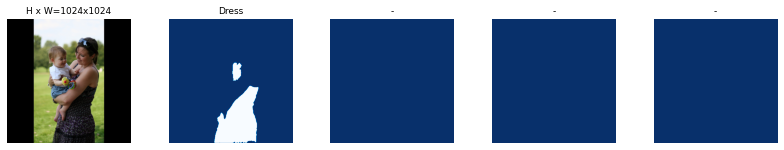

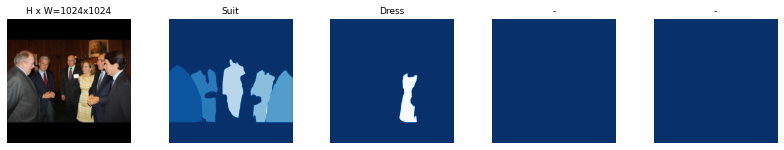

In [0]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names)

**IMAGE** AUGMENTATION

In [0]:
augmentation = iaa.Sequential([
    #geometric transform
    iaa.OneOf([ 
        iaa.Affine(
            scale={'x': (0.98, 1.02), 'y': (0.98, 1.02)},
            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)}, #{'x': (-0.02, 0.02), 'y': (-0.04, 0.04)},
            rotate=(-10, 10), #(-2, 2),
            shear=(-5, 5), #(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),

    #flip images left-right
    iaa.Fliplr(0.35),
    
    #brightness or contrast
    iaa.OneOf([
        iaa.Multiply((0.8, 1.2)), #(0.9, 1.1)),
        iaa.ContrastNormalization((0.8, 1.2)), #(0.9, 1.1)),
    ]),
    
    #blur or sharpen
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0.0, 0.25)),
        iaa.Sharpen(alpha=(0.0, 0.25)),
    ]),
])

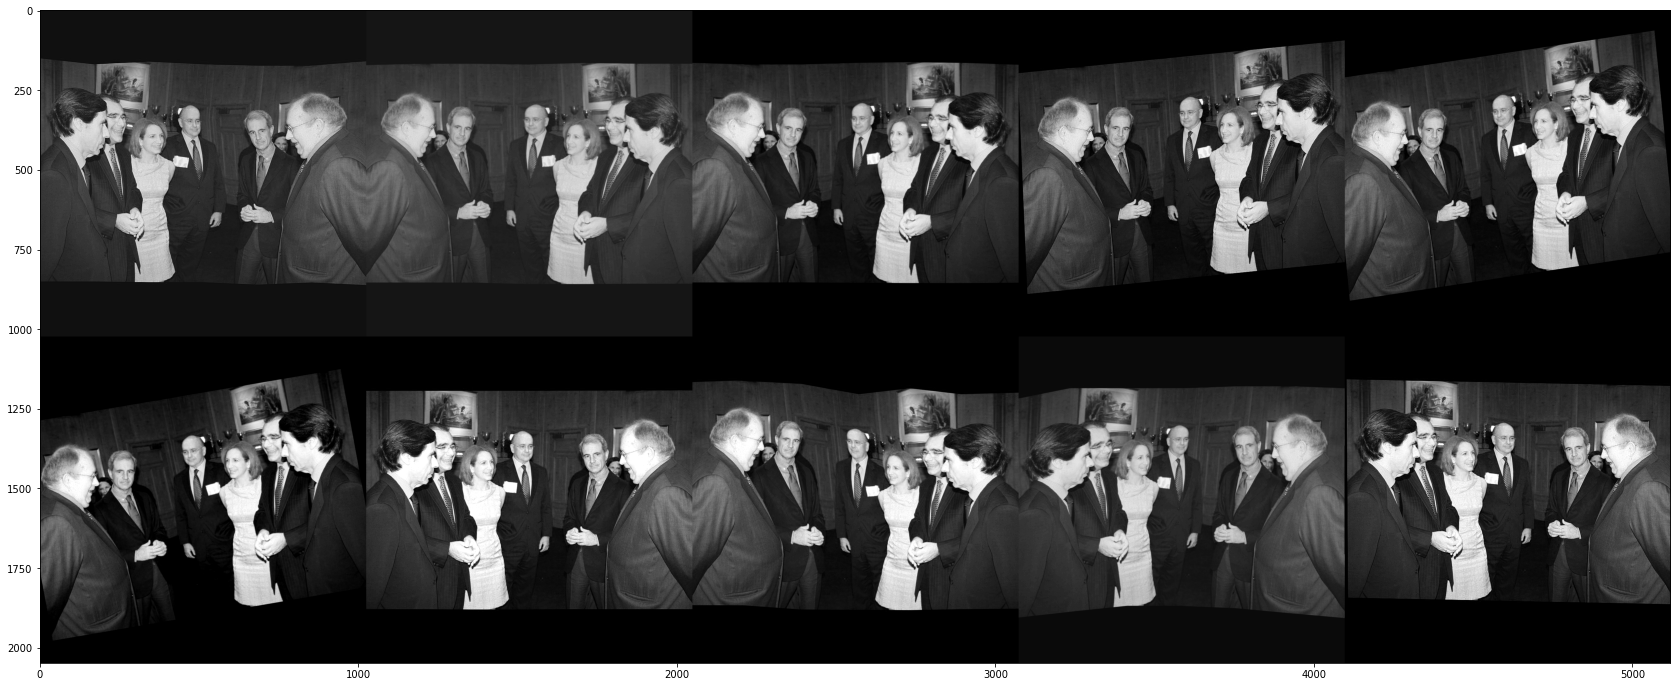

In [0]:
#test on the last image of the loop
imggrid = augmentation.draw_grid(image[:,:,0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:,:,0], cmap='gray')

TRANSFER LEARNING ON MASK RCNN

In [0]:
model = buildMASKRCNN(config=config, model_dir="./")

#exclude the last few layers from training for ResNet101
#exclude the last layers is to match the number of classes in the new dataset
model.load_weights('./mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=40, 
            learning_rate=config.LEARNING_RATE, 
            layers='heads'
            ,augmentation=augmentation
            )


Starting at epoch 0. LR=0.001

Checkpoint Path: ./maskrcnn_config20200408T0847/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/40
131/131 [==============================] - 97s 742ms/step - loss: 14.4394 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 12.4685 - mrcnn_class_loss: 0.4532 - mrcnn_bbox_loss: 0.7970 - mrcnn_mask_loss: 0.6852 - val_loss: 6.0388 - val_rpn_class_loss: 0.0193 - val_rpn_bbox_loss: 4.4598 - val_mrcnn_class_loss: 0.2671 - val_mrcnn_bbox_loss: 0.7672 - val_mrcnn_mask_loss: 0.5253

Epoch 2/40
131/131 [==============================] - 56s 431ms/step - loss: 9.8097 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 8.4836 - mrcnn_class_loss: 0.2804 - mrcnn_bbox_loss: 0.5824 - mrcnn_mask_loss: 0.4357 - val_loss: 5.8852 - val_rpn_class_loss: 0.0138 - val_rpn_bbox_loss: 4.6031 - val_mrcnn_class_loss: 0.2332 - val_mrcnn_bbox_loss: 0.5859 - val_mrcnn_mask_loss: 0.4491
Epoch 3/40
131/131 [==============================] - 57s 436ms/step - loss: 6.8787 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 5.8241 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.3729 - val_loss: 8.0243 - val_

In [0]:
history = model.keras_model.history.history

Fine Tune ALL layers

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=60, 
            learning_rate=config.LEARNING_RATE, 
            layers='all'
            ,augmentation=augmentation
            )


Starting at epoch 40. LR=0.001

Checkpoint Path: ./maskrcnn_config20200408T0847/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 41/60
131/131 [==============================] - 151s 1s/step - loss: 5.2498 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 4.5435 - mrcnn_class_loss: 0.1777 - mrcnn_bbox_loss: 0.2270 - mrcnn_mask_loss: 0.2869 - val_loss: 4.5323 - val_rpn_class_loss: 0.0115 - val_rpn_bbox_loss: 3.6170 - val_mrcnn_class_loss: 0.1342 - val_mrcnn_bbox_loss: 0.3287 - val_mrcnn_mask_loss: 0.4410
Epoch 42/60
131/131 [==============================] - 83s 631ms/step - loss: 5.5232 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 4.7603 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.2194 - mrcnn_mask_loss: 0.2751 - val_loss: 3.9096 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 2.9983 - val_mrcnn_class_loss: 0.1296 - val_mrcnn_bbox_loss: 0.3593 - val_mrcnn_mask_loss: 0.4127
Epoch 43/60
131/131 [==============================] - 83s 630ms/step - loss: 5.5595 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 4.8498 - mrcnn_class_loss: 0.2098 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.2671 - val_loss: 5.0813 - val_rpn_

In [0]:
new_history = model.keras_model.history.history
for k in new_history:
    history[k] = history[k] + new_history[k]

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=80, 
            learning_rate=config.LEARNING_RATE, 
            layers='all'
            ,augmentation=augmentation
            )


Starting at epoch 60. LR=0.001

Checkpoint Path: ./maskrcnn_config20200408T0847/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 61/80
131/131 [==============================] - 152s 1s/step - loss: 2.6939 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 2.1386 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1594 - mrcnn_mask_loss: 0.2514 - val_loss: 3.1524 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 2.3798 - val_mrcnn_class_loss: 0.1645 - val_mrcnn_bbox_loss: 0.2540 - val_mrcnn_mask_loss: 0.3457
Epoch 62/80
131/131 [==============================] - 82s 625ms/step - loss: 2.8682 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 2.3039 - mrcnn_class_loss: 0.1914 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2185 - val_loss: 2.5134 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 1.8056 - val_mrcnn_class_loss: 0.0968 - val_mrcnn_bbox_loss: 0.2251 - val_mrcnn_mask_loss: 0.3787
Epoch 63/80
131/131 [==============================] - 83s 634ms/step - loss: 2.1339 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.6230 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2287 - val_loss: 2.6315 - val_rpn_

In [0]:
new_history = model.keras_model.history.history
for k in new_history:
    history[k] = history[k] + new_history[k]

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=100, 
            learning_rate=config.LEARNING_RATE, 
            layers='all'
            ,augmentation=augmentation
            )


Starting at epoch 80. LR=0.001

Checkpoint Path: ./maskrcnn_config20200408T0847/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 81/100
131/131 [==============================] - 152s 1s/step - loss: 1.5646 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 1.1151 - mrcnn_class_loss: 0.1178 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.2161 - val_loss: 3.0863 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 2.3337 - val_mrcnn_class_loss: 0.1242 - val_mrcnn_bbox_loss: 0.2638 - val_mrcnn_mask_loss: 0.3557
Epoch 82/100
131/131 [==============================] - 82s 629ms/step - loss: 1.7390 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.2766 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.1971 - val_loss: 3.2632 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 2.4991 - val_mrcnn_class_loss: 0.1436 - val_mrcnn_bbox_loss: 0.2458 - val_mrcnn_mask_loss: 0.3661
Epoch 83/100
131/131 [==============================] - 83s 632ms/step - loss: 1.2893 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.8558 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.2072 - val_loss: 2.8729 - val_r

In [0]:
new_history = model.keras_model.history.history
for k in new_history:
    history[k] = history[k] + new_history[k]

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=120, 
            learning_rate=config.LEARNING_RATE, 
            layers='all'
            ,augmentation=augmentation
            )


Starting at epoch 100. LR=0.001

Checkpoint Path: ./maskrcnn_config20200408T0847/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 101/120
131/131 [==============================] - 154s 1s/step - loss: 1.3215 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.9375 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.2024 - val_loss: 3.1641 - val_rpn_class_loss: 0.0079 - val_rpn_bbox_loss: 2.3790 - val_mrcnn_class_loss: 0.1757 - val_mrcnn_bbox_loss: 0.2340 - val_mrcnn_mask_loss: 0.3674
Epoch 102/120
131/131 [==============================] - 82s 630ms/step - loss: 1.3281 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.9383 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1778 - val_loss: 2.8790 - val_rpn_class_loss: 0.0079 - val_rpn_bbox_loss: 2.1065 - val_mrcnn_class_loss: 0.1586 - val_mrcnn_bbox_loss: 0.2486 - val_mrcnn_mask_loss: 0.3574
Epoch 103/120
131/131 [==============================] - 83s 635ms/step - loss: 0.9990 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.6250 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1853 - val_loss: 2.6063 - va

In [0]:
new_history = model.keras_model.history.history
for k in new_history:
    history[k] = history[k] + new_history[k]

In [0]:
import pandas as pd
epochs = range(1, len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
1    6.038769            0.019296  ...         0.797008         0.685192
2    5.885163            0.013848  ...         0.582422         0.435741
3    8.024328            0.015651  ...         0.414877         0.372921
4    6.361918            0.013832  ...         0.384865         0.385614
5    7.489464            0.012295  ...         0.401403         0.410057
..        ...                 ...  ...              ...              ...
116  2.685921            0.007532  ...         0.051120         0.150985
117  2.950021            0.008242  ...         0.049518         0.139451
118  3.136387            0.010832  ...         0.062121         0.175749
119  3.204157            0.009069  ...         0.064894         0.166801
120  2.897112            0.008769  ...         0.057316         0.159855

[120 rows x 12 columns]

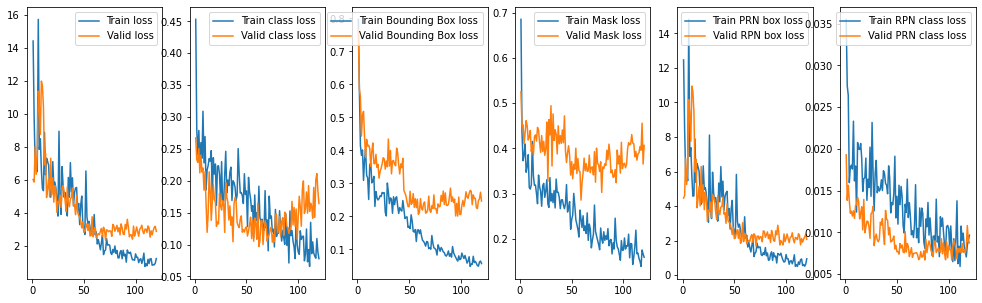

In [0]:
plt.figure(figsize=(17,5))

plt.subplot(161)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(162)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class loss")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class loss")
plt.legend()
plt.subplot(163)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train Bounding Box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid Bounding Box loss")
plt.legend()
plt.subplot(164)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()
plt.subplot(165)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train PRN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(166)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class loss")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid PRN class loss")
plt.legend()


plt.show()

In [0]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 71 2.352111974954605
